In [1]:

from google.colab import drive
drive.mount('/content/drive')

root_path = '/content/drive/MyDrive/CVDL'
dumps_path =  f"{root_path}/dumps/"
dataset  = f"{root_path}/dataset/"

!cp "$root_path/modules/lib.py" .
!cp "$root_path/modules/plots.py" .
!cp "$root_path/modules/metrics.py" .


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing

## Imports

In [2]:
import cv2
import pickle
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import tensorflow as tf
import importlib
from datetime import datetime

from keras.initializers import glorot_uniform

import lib
import plots
import metrics

tf.keras.backend.clear_session()

## Parameters

In [3]:
# Deafault Res: 606x468 (ar 101 : 78)

# Tested Res's:
# 224x160 (ar 7 : 5)
# 384x288
# 576x432
# 512x384
input_res = (384, 288)

seed = 42

params = {
          'x':input_res[0],                                
          'y':input_res[1],                                
          'batch_size': 8,                        
          'n_channels_mask': 1,                            
          'n_channels': 1,                        
          'shuffle': True,              
          'learningRate': 1e-3,                      
          'momentum': 0.98,                        
          'nEpoches': 100,                        
          }

ratio_test = 0.85
ratio_val  = 0.8

lib.create_dump([params, seed], dumps_path + "params_du")

type_ds  = ['Images','Masks']
modality = ['train','validation','test']

# get path Img and Mask
path_img  = os.path.join(dataset, type_ds[0])
path_msk  = os.path.join(dataset, type_ds[1])
path_     = [path_img, path_msk]

# get length imgs and proof that is equal with masks
length_imgs  = len(os.listdir(os.path.join(dataset,type_ds[0] + "/"))) 
length_masks = len(os.listdir(os.path.join(dataset,type_ds[1] + "/")))
params['length_data'] = length_imgs,

# get name of file imgs
imgs_list_path = os.listdir(path_img)

## Data loading 

In [4]:
# LOAD & SPLIT DATA ============================================================
'''
mode = 1  # mode = 0: Random Split
          # mode = 1: Split for Patients
          
dataset_list = lib.get_dataset_list(
                                mode, 
                                path_, 
                                imgs_list_path, 
                                params, 
                                ratio_test, 
                                ratio_val, 
                                seed, 
                                modality)

# Dumping splitted data
lib.create_dump(dataset_list, f"{dumps_path}data_rt{ratio_test}_rv{ratio_val}_{input_res[0]}x{input_res[1]}")

'''

'\nmode = 1  #\xa0mode = 0: Random Split\n          #\xa0mode = 1: Split for Patients\n          \ndataset_list = lib.get_dataset_list(\n                                mode, \n                                path_, \n                                imgs_list_path, \n                                params, \n                                ratio_test, \n                                ratio_val, \n                                seed, \n                                modality)\n\n# Dumping splitted data\nlib.create_dump(dataset_list, f"{dumps_path}data_rt{ratio_test}_rv{ratio_val}_{input_res[0]}x{input_res[1]}")\n\n'

##Loading Data from Pickle

In [5]:
dataset_list = pickle.load(open( f"{dumps_path}data_rt{ratio_test}_rv{ratio_val}_{input_res[0]}x{input_res[1]}", "rb" ))

##Data Augmentation

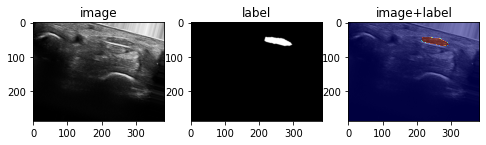

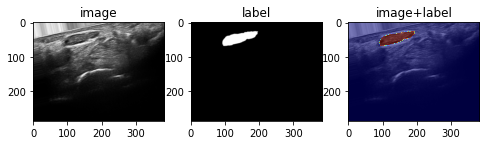

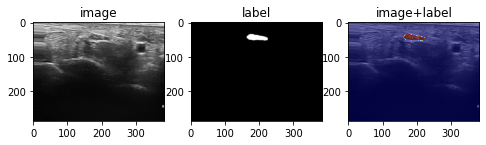

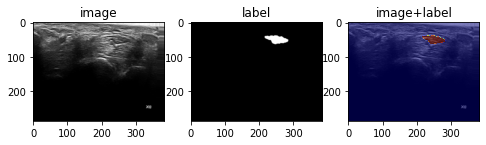

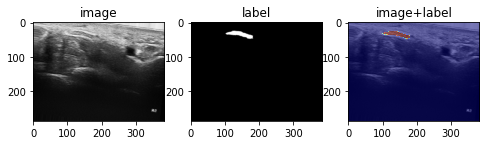

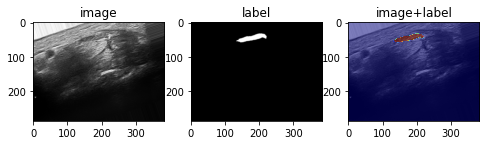

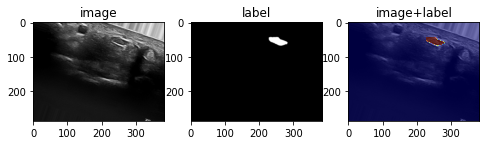

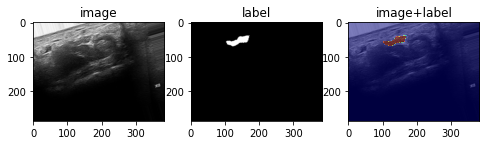

In [6]:
# DATA AUGMENTATION ============================================================
train_generator, val_generator = lib.data_augmentation(seed, dataset_list, params)

params["length_training"]   = len(dataset_list[0]['train'])
params['length_validation'] = len(dataset_list[0]['validation'])

augmented_batch_plot = plots.plot_augmented_batch(train_generator)
plt.show()

In [7]:
print(params["length_training"])
print(params['length_validation'])
print(len(dataset_list[0]['test']))

164
38
44


# Model definition & training

## Training

In [8]:
params['learningRate'] = 1e-3
params['nEpoches'] = 100


models_name = ['unet', 'lightweight_unet', 'dbunet', 'dbunet_BNDrop', 'dbunet_BN', 'doubleunet']
arch_name = models_name[5]
model_weights = f"{root_path}/dataset/results/models/{arch_name}_e{params['nEpoches']}_lr{params['learningRate']}"
!rm -rf $model_weights
log_path = f"{model_weights}/logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
!cp "$root_path/modules/models/{arch_name}.py" .
arch = importlib.import_module(arch_name)


input_size = (input_res[1], input_res[0], 1)
initializer = tf.keras.initializers.GlorotUniform()
#model = arch.build_model(initializer, input_size)
model = arch.build_model(input_size)

#model.summary()

In [9]:
# Model savepath
#now = datetime.now()
#current_time = now.strftime("%H:%M:%S")

# Default loss, metric
#loss = 'binary_crossentropy'
#metric = 'accuracy'
loss      = metrics.bce_dice_loss
recall    = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()
metric    = [metrics.dice, metrics.iou, recall, precision]

print(f'Model wil be saved in {model_weights}')

train_history, model = lib.train(model_weights, log_path, params, model, loss, metric, train_generator, val_generator)


Model wil be saved in /content/drive/MyDrive/CVDL/dataset/results/models/doubleunet_e100_lr0.001


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/100
21/21 [==============================] - 40s 1s/step - loss: 1.5360 - dice: 0.0266 - iou: 0.0489 - recall: 0.8087 - precision: 0.0396 - val_loss: 1.5919 - val_dice: 2.8913e-04 - val_iou: 1.6034e-10 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.59192, saving model to /content/drive/MyDrive/CVDL/dataset/results/models/doubleunet_e100_lr0.001/Model.hdf5
Epoch 2/100
21/21 [==============================] - 13s 630ms/step - loss: 1.3418 - dice: 0.0388 - iou: 0.2048 - recall: 0.6834 - precision: 0.2049 - val_loss: 2.9843 - val_dice: 0.0332 - val_iou: 0.0179 - val_recall: 0.9957 - val_precision: 0.0190

Epoch 00002: val_loss did not improve from 1.59192
Epoch 3/100
21/21 [==============================] - 13s 627ms/step - loss: 1.2557 - dice: 0.0502 - iou: 0.3331 - recall: 0.6918 - precision: 0.3601 - val_loss: 1.6673 - val_dice: 0.0532 - val_iou: 0.0648 - val_recall: 0.9987 - val_precision: 0.0681

Epoch 00003: val_loss did not

## Evaluating

2/2 [==============================] - 14s 4s/step - loss: 0.1423 - dice: 0.8664 - iou: 0.7916 - recall: 0.8554 - precision: 0.8971


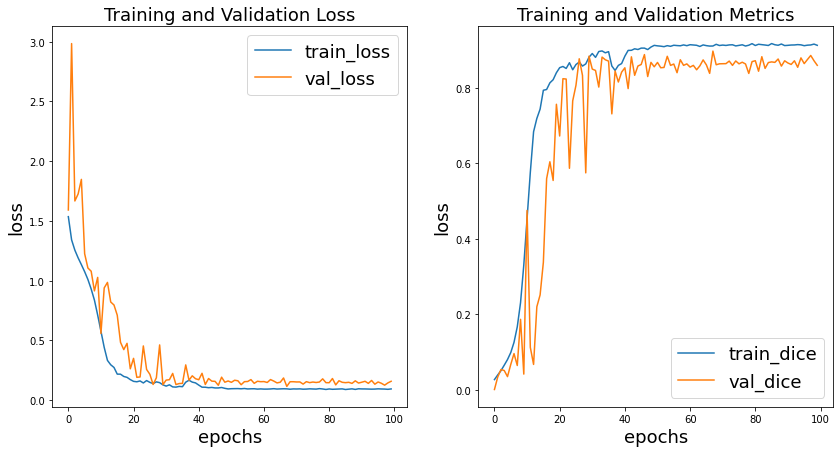

In [10]:
results_tf = model.evaluate(dataset_list[0]['test'], dataset_list[1]['test'], return_dict = True)
train_figure = plots.plot_train_metric(train_history.history, params['nEpoches'], "dice")
plt.show()

In [11]:
threshold = 0.5
min_dice = 0.60
results_df, avg = plots.get_results(dataset_list, params, model, threshold)
print(results_df)
print('\n')
print(f"Threshold value: {threshold}")
print(f"Best dice: {max(results_df['dice'])}")
print(f"Average dice: {results_df['dice'].describe()}")
print(f"Minimum requested dice value (bad samples): {min_dice}")
good_res = results_df.loc[(results_df['dice'] >= min_dice)]
print(f"Average dice without bad samples: {good_res['dice'].mean()}")

        dice
0   0.862903
1   0.855124
2   0.919978
3   0.934739
4   0.944882
5   0.942116
6   0.873768
7   0.918047
8   0.916737
9   0.926529
10  0.848652
11  0.899123
12  0.894423
13  0.637097
14  0.930050
15  0.942211
16  0.944824
17  0.924850
18  0.880478
19  0.718623
20  0.935630
21  0.917657
22  0.941764
23  0.963889
24  0.925908
25  0.881010
26  0.940568
27  0.833333
28  0.699042
29  0.941368
30  0.941975
31  0.956309
32  0.620583
33  0.933505
34  0.893669
35  0.915794
36  0.903945
37  0.904518
38  0.898638
39  0.852190
40  0.898780
41  0.914043
42  0.859710
43  0.697819


Threshold value: 0.5
Best dice: 0.9638888888888889
Average dice: count    44.000000
mean      0.883791
std       0.082921
min       0.620583
25%       0.871052
50%       0.914919
75%       0.934961
max       0.963889
Name: dice, dtype: float64
Minimum requested dice value (bad samples): 0.6
Average dice without bad samples: 0.8837909277069957


        dice
32  0.323878
0.022727272727272728


Loading bad samples... :






Image index 32 - dice: dice    0.323878
Name: 32, dtype: float64


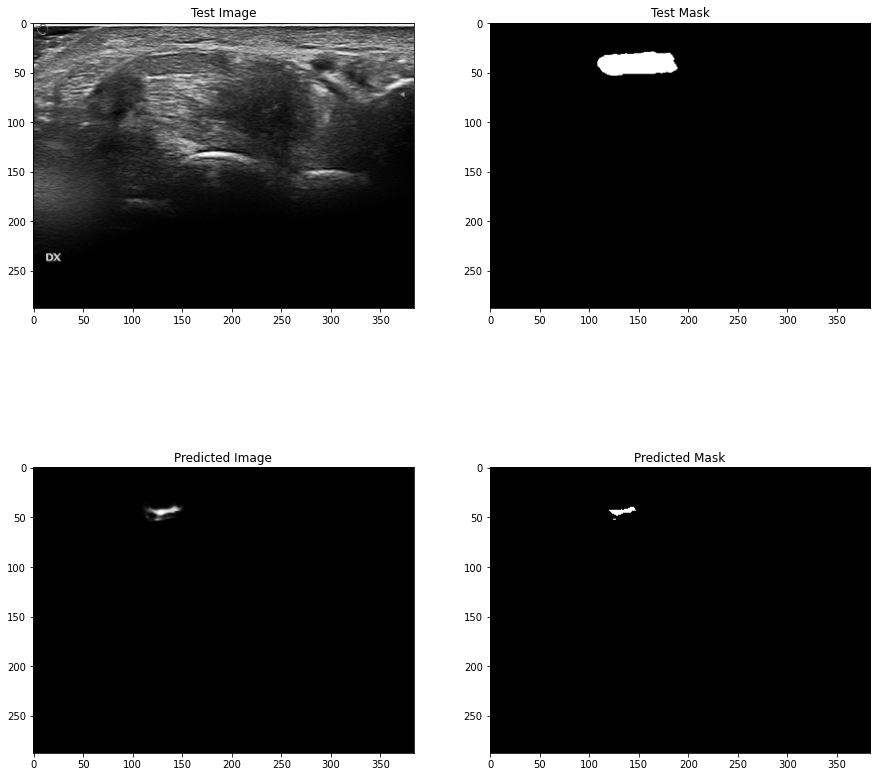

In [14]:
bad_res = results_df.loc[(results_df['dice'] < min_dice)]
print(bad_res)

num = bad_res['dice'].count()
den = results_df['dice'].count()

print(num/den)
print('\n')
print("Loading bad samples... :")
print('\n')
for idx in bad_res.index:
  print('\n')
  print('\n')
  print(f"Image index {idx} - dice: {bad_res.loc[idx]}")
  threshold = 0.5
  test_image = dataset_list[0]['test'][idx,:,:,0]
  test_mask = dataset_list[1]['test'][idx,:,:,0]
  test_results = lib.get_preditcions(test_image, test_mask, params, model, threshold)
  results_figure = plots.plot_test_results(test_results)

  plt.show()
#results_figure.savefig(f'/content/drive/MyDrive/CVDL/trained_models/{name}/bad_samples.png')

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 288, 384, 1) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 288, 384, 3)  0           input_1[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 288, 384, 64) 1792        concatenate[0][0]                
______________________________________________________________________________________________

## Saving

In [19]:
name = 'doubleunet_original_d0.8995'
model.save(f'/content/drive/MyDrive/CVDL/trained_models/{name}/model.h5', save_format='h5')
lib.create_dump(train_history.history, f'/content/drive/MyDrive/CVDL/trained_models/{name}/train_history')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
from tensorflow import keras

loss      = metrics.bce_dice_loss
recall    = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()
metric    = [metrics.dice, metrics.iou, recall, precision]

name = 'doubleunet_d0.9027'

c_objects = {
    "bce_dice_loss": metrics.bce_dice_loss,
    "dice": metrics.dice,
    "iou": metrics.iou,
    "precision": tf.keras.metrics.Precision(),
    "recall": tf.keras.metrics.Recall(),
}

loaded_model = keras.models.load_model(f'/content/drive/MyDrive/CVDL/trained_models/{name}/model.h5', custom_objects=c_objects)

loaded_model.compile(loss=metrics.bce_dice_loss, optimizer='adam', metrics=metric)

results_tf = loaded_model.evaluate(dataset_list[0]['test'], dataset_list[1]['test'], return_dict = True)

model = loaded_model

2/2 [==============================] - 3s 207ms/step - loss: 0.1147 - dice: 0.8860 - iou: 0.8145 - recall_1: 0.8499 - precision_1: 0.9460
